# A 2D version of the Robot Parking problem

Here is a 2D version of the Robot parking problem. Credits for this implemention to  [Thijs van de Laar](https://biaslab.github.io/member/thijs) and [Burak Ergul](https://biaslab.github.io/member/burak). 


In [1]:
using Random
Random.seed!(87613) # Set random seed

using LinearAlgebra
using PyPlot
using ForneyLab

include("environment_2d.jl") # Include environmental dynamics
include("helpers_2d.jl") # Include helper functions for plotting
include("agent_2d.jl") # Load agent's internal beliefs over external dynamics
;

### Build model

We define the state of the robot (at time $k$) as the current orientation and Cartesian coordinates:
\begin{align}
    s_k = (ϕ_k, x_k, y_k)^{T}\,.
\end{align}

The control consists of a change in orientation and subsequent travel distance:
\begin{align}
    u_k = (\Delta\phi_k, r_k)^{T}\,.
\end{align}

The model factorization did not change:
\begin{align}
    p_t(o, s, u) &\propto p(s_{t-1}) \prod_{k=t}^{t+T} p(o_k | s_k)\, p(s_k | s_{k-1}, u_k)\, p(u_k)\, \tilde{p}(o_k)\,.
\end{align}

The specific model assumptions however now include a non-linear transition function $g$:
\begin{align}
    p(s_{t-1}) &= \mathcal{N}(s_{t-1} | m_{s, t-t}, V_{s, t-1})\\
    p(s_k | s_{k-1}, u_k) &= \mathcal{N}(s_k | g(s_{k-1}, u_k), \Gamma^{-1})\\
    p(o_k | s_k) &= \mathcal{N}(o_k | s_k, \Phi^{-1})\\
    p(u_k) &= \mathcal{N}(u_k | 0, \Upsilon) \text{, for } k>t\\
    \tilde{p}(o_k) &= \mathcal{N}(o_k | 0, \Sigma) \text{, for } k>t\\
    p(u_t) &= \delta(u_t - \hat{u}_t)\\
    \tilde{p}(o_t) &= \delta(o_t - \hat{o}_t)\,.
\end{align}

In [2]:
# Internal model perameters
Gamma   = 100.0*diageye(3) # Transition precision
Phi     = 10.0*diageye(3) # Observation precision
Upsilon = Diagonal([0.25*pi, 1.0].^2) # Control prior variance
Sigma   = Diagonal([1.0, 30.0, 30.0]) # Goal prior variance
;

In [3]:
T = 10 # Lookahead

# Build internal model
fg = FactorGraph()

o   = Vector{Variable}(undef, T) # Observed states
s_g = Vector{Variable}(undef, T) # Noiseless internal states
s   = Vector{Variable}(undef, T) # Noisy internal states
u   = Vector{Variable}(undef, T) # Control states

@RV s_t_min ~ GaussianMeanVariance(placeholder(:m_s_t_min, dims=(3,)),
                                   placeholder(:V_s_t_min, dims=(3,3))) # Prior internal state
u_t = placeholder(:u_t, dims=(2,))
@RV u[1]   ~ GaussianMeanVariance(u_t, tiny*diageye(2))
@RV s_g[1] ~ Nonlinear(s_t_min, u[1], g, g_inv_in1=g_inv_in1, g_inv_in2=g_inv_in2)
@RV s[1]   ~ GaussianMeanPrecision(s_g[1], Gamma)
@RV o[1]   ~ GaussianMeanPrecision(s[1], Phi)
placeholder(o[1], :o_t, dims=(3,))

s_k_min = s[1]
for k=2:T
    @RV u[k]   ~ GaussianMeanVariance(zeros(2), Upsilon)
    @RV s_g[k] ~ Nonlinear(s_k_min, u[k], g, g_inv_in1=g_inv_in1, g_inv_in2=g_inv_in2) # Noiseless transition model
    @RV s[k]   ~ GaussianMeanPrecision(s_g[k], Gamma) # State transition model including noise
    @RV o[k]   ~ GaussianMeanPrecision(s[k], Phi) # Observation model
    GaussianMeanVariance(o[k], 
                         placeholder(:m_o, var_id=:m_o_*k, index=k-1, dims=(3,)),
                         placeholder(:V_o, var_id=:V_o_*k, index=k-1, dims=(3,3))) # Goal prior
    s_k_min = s[k]
end
;

### Infer algorithm

In [4]:
# Schedule message passing algorithm
algo = sumProductAlgorithm(u[2]) # Infer internal states
eval(Meta.parse(algo)) # Loads the step!() function for inference
inspectSnippet(algo) # Inspect a snippet of the algorithm code
;

function step!(data::Dict, marginals::Dict=Dict(), messages::Vector{Message}=Array{Message}(undef, 59))

messages[1] = ruleSPGaussianMeanVarianceOutNPP(nothing, Message(Multivariate, PointMass, m=[0.0, 0.0]), Message(MatrixVariate, PointMass, m=Diagonal([0.6168502750680849, 1.0])))
messages[2] = ruleSPGaussianMeanVarianceOutNPP(nothing, Message(Multivariate, PointMass, m=data[:m_s_t_min]), Message(MatrixVariate, PointMass, m=data[:V_s_t_min]))
messages[3] = ruleSPGaussianMeanVarianceOutNPP(nothing, Message(Multivariate, PointMass, m=data[:u_t]), Message(MatrixVariate, PointMass, m=Diagonal([1.0e-12, 1.0e-12])))

...

marginals[:u_2] = messages[1].dist * messages[59].dist

return marginals

end


### Execute algorithm

In [5]:
# Initial state
ϕ_0 = pi # Initial orientation
x_0 = 2.0 # Initial coordinates
y_0 = 3.0
;

In [6]:
N = 20 # Total simulation time

(execute, observe)  = initializeWorld() # Let there be a world
(infer, act, slide) = initializeAgent() # Let there be an agent

# Step through action-perception loop
u_hat = Vector{Vector{Float64}}(undef, N) # Actions
o_hat = Vector{Vector{Float64}}(undef, N) # Observations
for t=1:N
    u_hat[t] = act() # Evoke an action from the agent
               execute(u_hat[t]) # The action influences hidden external states
    o_hat[t] = observe() # Observe the current environmental outcome (update p)
               infer(u_hat[t], o_hat[t]) # Infer beliefs from current model state (update q)
               slide() # Prepare for next iteration
end
;

### and plot the position track

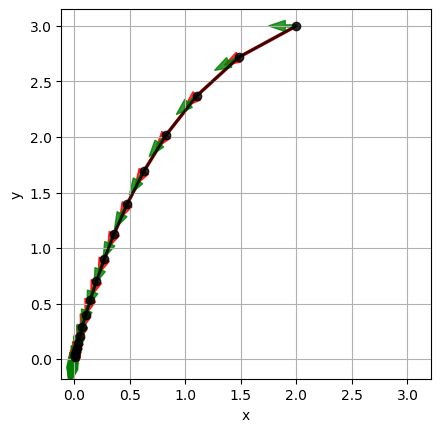

In [7]:
# Plot active inference results
plotTrajectory(u_hat, o_hat)
;